<a href="https://colab.research.google.com/github/AlexBerryhill/CNN-German_Signs/blob/main/CNN_German_Signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [337]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
import os
if not os.path.exists('./content/training'):
    !echo "Downloading files..."
    !wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
    !wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
    !wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/holdout.zip
    !wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout.zip
    !wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout_answers.csv

    !echo "Unzipping files..."
    !unzip -q /content/training1.zip
    !unzip -q /content/training2.zip
    !unzip -q /content/holdout.zip
    !unzip -q /content/mini_holdout.zip

    # Combine the two traning directories
    !echo "Merging training data..."
    !mkdir /content/training
    !mv /content/training1/* /content/training
    !mv /content/training2/* /content/training

    # Cleanup
    !echo "Cleaning up..."
    !rmdir /content/training1
    !rmdir /content/training2
    !rm training1.zip
    !rm training2.zip
    !rm holdout.zip
    !rm mini_holdout.zip

    !echo "Data ready."

In [338]:
# Import libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score, accuracy_score, ConfusionMatrixDisplay


In [339]:
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation.


training_dir = './content/training/'
image_size = (100, 100)

# from skimage import exposure

# def contrast_stretching(img):
#     p2, p98 = np.percentile(img, (2, 98))
#     img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
#     return img_rescale

# Split up the training data images into training and validations sets
# We'll use and ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and agumentation on the files as can be seen with rescale

import cv2

def sharpen_image(image):
    # Convert the image to RGB format (assuming it's in BGR)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create a sharpening kernel
    kernel = np.array([[-1, 0, -1],
                       [0, 8, 0],
                       [-1, 0, -1]])

    # Apply the sharpening kernel using cv2.filter2D
    sharpened = cv2.filter2D(image_rgb, -1, kernel)

    return sharpened

def unsharp_mask(image):
    blurred = cv2.GaussianBlur(image, (0, 0), 2.0)
    sharpened = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)
    return sharpened

def threshold_image(image):
    _, thresholded = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY)
    return thresholded

def contrast_stretching(image):
    # Convert the image to RGB format (assuming it's in BGR)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Calculate minimum and maximum pixel values
    min_val = image_rgb.min(axis=(0, 1))
    max_val = image_rgb.max(axis=(0, 1))

    # Check if max_val and min_val are equal for any channel
    equal_min_max = np.all(min_val == max_val)

    # Perform contrast stretching only if min_val and max_val are not equal
    stretched = np.zeros_like(image_rgb, dtype=np.uint8)
    if not equal_min_max:
        stretched = ((image_rgb - min_val) * 255) // (max_val - min_val)

    return stretched

def morphological_operations(image):
    kernel = np.ones((3, 3), np.uint8)
    dilated = cv2.dilate(image, kernel, iterations=1)
    eroded = cv2.erode(dilated, kernel, iterations=1)
    return eroded

PREPROCESSING_FUNCTION = None

train_datagen = ImageDataGenerator(
    preprocessing_function=PREPROCESSING_FUNCTION,
    rescale=1./255,
    validation_split=.2,
    brightness_range=[0.3, 1.5],
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=2.0,
    height_shift_range=2.0,
    fill_mode='nearest',
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=PREPROCESSING_FUNCTION,
    rescale=1./255,
    validation_split=.2,
    brightness_range=[0.3, 1.5],
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=2.0,
    height_shift_range=2.0,
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,shuffle=True)
validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42)



Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [340]:
#these might come in handy
target_names = ['Speed_20', 'Speed_30', 'Speed_50', 'Speed_60', 'Speed_70',
               'Speed_80','Speed_Limit_Ends', 'Speed_100', 'Speed_120', 'Overtaking_Prohibited',
               'Overtakeing_Prohibited_Trucks', 'Crossroad_Ahead', 'Priority_Road_Ahead', 'Yield', 'STOP',
               'Entry_Forbidden', 'Trucks_Forbidden', 'No_Entry(one-way traffic)', 'Cars_Prohibited(!)', 'Left_Curve_Ahead',
               'Right_Curve_Ahead', 'Bends_Left_Then_Right', 'Poor_Surface_Ahead', 'Slippery_Surface_Ahead', 'Road_Narrows_On_Right',
               'Roadwork_Ahead', 'Traffic_Light_Ahead', 'Warning_Pedestrians', 'Warning_Children', 'Warning_Bikes',
               'Uncontrolled_Crossroad', 'Deer_Crossing', 'End_Previous_Limitation', 'Turning_Right_Compulsory', 'Turning_Left_Compulsory',
               'Ahead_Only', 'Straight_Or_Right_Mandatory', 'Straight_Or_Left_Mandatory', 'Passing_Right_Compulsory', 'Passing_Left_Compulsory',
               'Roundabout', 'End_Overtaking_Prohibition', 'End_Overtaking_Prohibition_Trucks']

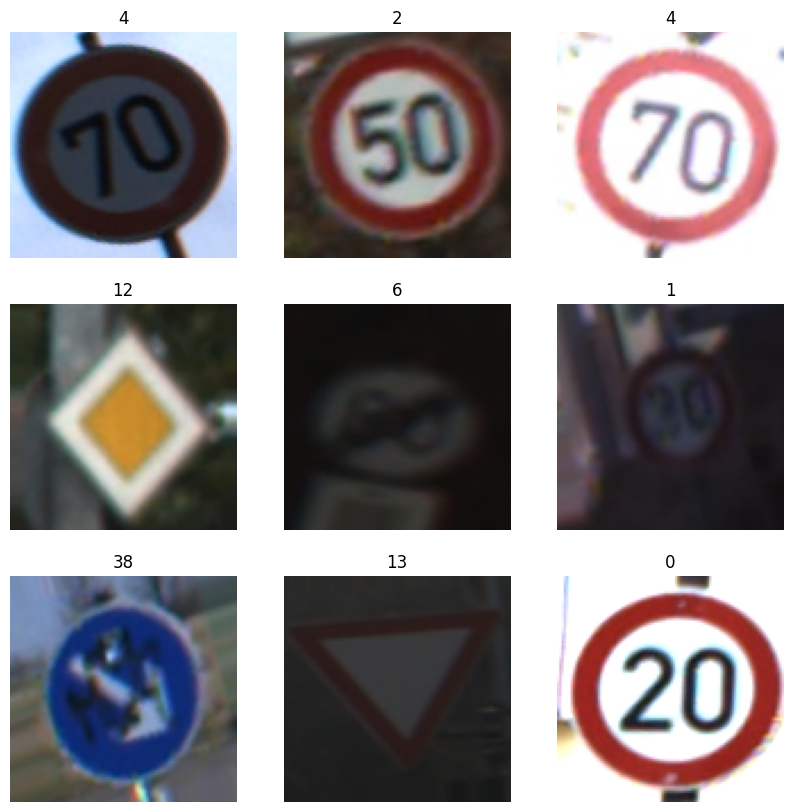

In [341]:
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(9):
        first_image = images.tolist()[i]
        ax = plt.subplot(3, 3, i + 1)
        f = np.array(first_image)*255
        plt.imshow(f.astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
    break

# Building Model

In [342]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  # Added dropout layer for blurry photos

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  # Added dropout layer

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  # Added dropout layer

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  # Added dropout layer

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))  # Added dropout layer

model.add(Flatten())

model.add(Dense(128, activation='swish'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Added dropout layer
model.add(Dense(64, activation='swish'))
model.add(Dense(len(target_names), activation='softmax'))

# Define the ReduceLROnPlateau callback
# This will slowly reduce our lr as we hit a plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c:\Users\alepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


## Training Model

In [343]:
history = model.fit(train_generator, epochs=30, validation_data=validation_generator, callbacks=[reduce_lr])

Epoch 1/30


c:\Users\alepa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


981/981 ━━━━━━━━━━━━━━━━━━━━ 119s 119ms/step - accuracy: 0.2518 - loss: 2.8042 - val_accuracy: 0.7496 - val_loss: 0.7998 - learning_rate: 0.0010
Epoch 2/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 105s 107ms/step - accuracy: 0.7829 - loss: 0.6789 - val_accuracy: 0.9077 - val_loss: 0.3103 - learning_rate: 0.0010
Epoch 3/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 109s 110ms/step - accuracy: 0.8951 - loss: 0.3188 - val_accuracy: 0.9199 - val_loss: 0.2739 - learning_rate: 0.0010
Epoch 4/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 107s 109ms/step - accuracy: 0.9257 - loss: 0.2366 - val_accuracy: 0.9333 - val_loss: 0.2311 - learning_rate: 0.0010
Epoch 5/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 108s 110ms/step - accuracy: 0.9482 - loss: 0.1697 - val_accuracy: 0.9436 - val_loss: 0.1793 - learning_rate: 0.0010
Epoch 6/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 107s 109ms/step - accuracy: 0.9531 - loss: 0.1517 - val_accuracy: 0.9439 - val_loss: 0.1921 - learning_rate: 0.0010
Epoch 7/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 108s 110ms/step - accuracy: 0.9588 

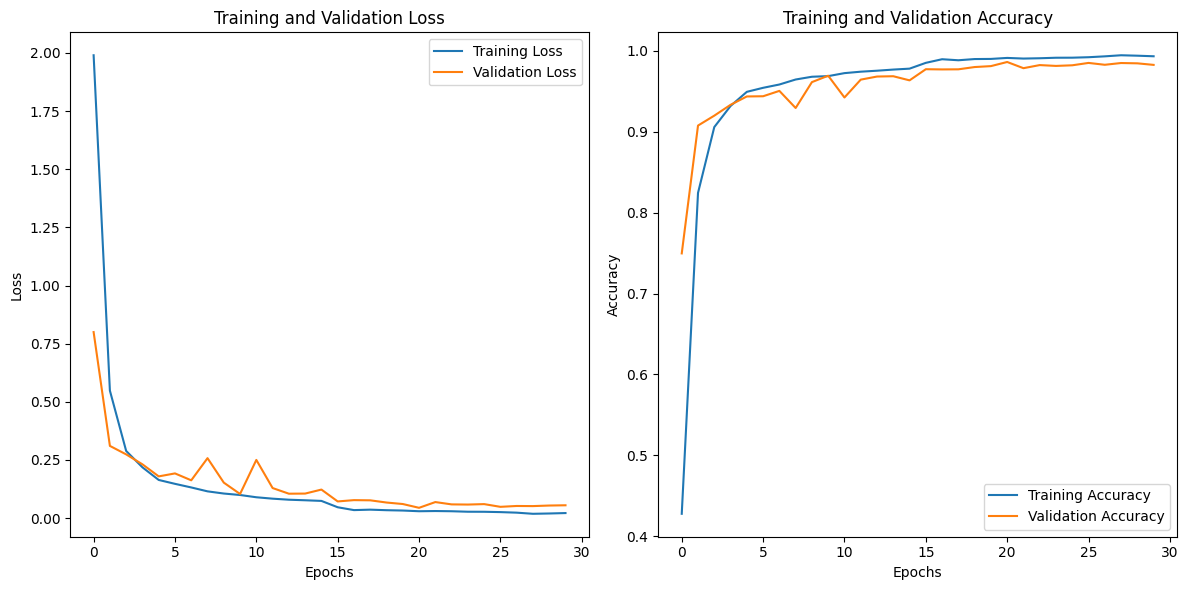

In [344]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Testing the model

In [364]:
# Let's take a look at some images our model got wrong
# First, we'll get the predicted labels for the validation data
validation_images, validation_labels = next(validation_generator)
predicted_labels = np.argmax(model.predict(validation_images), axis=1)

# Convert labels to integers
validation_labels_int = validation_labels.astype(int)
predicted_labels_int = predicted_labels.astype(int)

# Now, we'll find the indices of the misclassified images
misclassified_indices = np.where(predicted_labels != validation_labels)[0]

# Finally, we'll plot the misclassified images
plt.figure(figsize=(10, 10))
for i, index in enumerate(misclassified_indices):
    if i >= 9:
        break
    image = validation_images[index]
    ax = plt.subplot(3, 3, i + 1)
    f = np.array(image) * 255
    plt.imshow(f.astype("uint8"))

    # Use the corresponding target names for actual and predicted labels
    actual_label = target_names[validation_labels_int[index]]
    predicted_label = target_names[predicted_labels_int[index]]

    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")

    plt.axis("off")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1000x1000 with 0 Axes>

Found 201 images belonging to 1 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
-------------------------------- RESULTS ---------------------------------

Accuracy: 99.50248756218906%



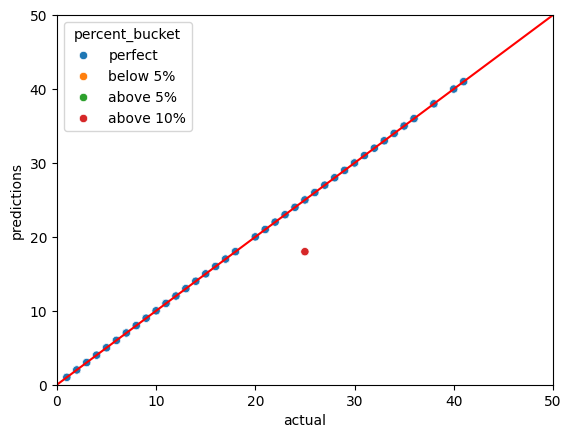

-----------------------------------------------------------------------------






In [346]:
# Load unlabeled images
test_dir = './content/'
test_datagen = ImageDataGenerator(
        rescale=1./255,
        # brightness_range=[0.5, 1.5],
        preprocessing_function=PREPROCESSING_FUNCTION
        )
test_generator = test_datagen.flow_from_directory(
    test_dir,
    classes=['mini_holdout'],
    target_size=image_size,
    class_mode=None,  # No class mode for unlabeled data
    shuffle=False
)

# Predict labels for unlabeled images
probabilities = model.predict(test_generator)
predictions = np.argmax(probabilities, axis=1)

# Load ground truth labels
answers_df = pd.read_csv('./content/mini_holdout_answers.csv')
ground_truth = answers_df['ClassId'].values

# Evaluate predictions
#precision = precision_score(ground_truth, predictions)
#recall = recall_score(ground_truth, predictions)
#f1 = f1_score(ground_truth, predictions)

# Calculate accuracy
correct_predictions = np.sum(predictions == ground_truth)
total_samples = len(ground_truth)
accuracy = correct_predictions / total_samples * 100


# Create a DataFrame for visualization
testfinal = pd.DataFrame({
    'actual': ground_truth,
    'predictions': predictions
})

# Add a column for percent_bucket (customize this based on your requirements)
testfinal['percent_bucket'] = pd.cut(
    abs((testfinal['actual'] - testfinal['predictions']) / testfinal['actual']),
    bins=[-np.inf, 0.05, 0.1, 0.2, np.inf],
    labels=['perfect', 'below 5%', 'above 5%', 'above 10%']
)

# Display results
print(f"-------------------------------- RESULTS ---------------------------------\n")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1: {f1}")
print(f"Accuracy: {accuracy}%\n")

color_dict = dict({'perfect': 'tab:blue', 'below 5%': 'tab:orange', 'above 5%': 'tab:green', 'above 10%': 'tab:red'})
ax = sns.scatterplot(data=testfinal, x='actual', y='predictions', hue="percent_bucket", palette=color_dict)
ax.plot([0, 1e3], [0, 1e3], color='r')

# Adjust axis limits
xlims = (0, 50)  # Modify as needed
ylims = (0, 50)  # Modify as needed
ax.set(xlim=xlims, ylim=ylims)

plt.show()
print(f"-" * 77)
print("\n" * 3)


In [347]:
if accuracy > 99:
    print(f"Accuracy is greater than 99% ({accuracy}%).")
    print("Saving model...")
    model.save('MoreThan99Model.keras')

Accuracy is greater than 99% (99.50248756218906%).
Saving model...


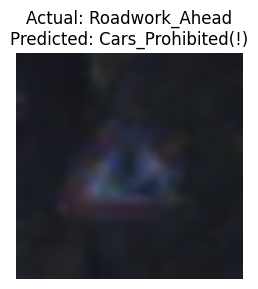

In [348]:
# Identify misclassified images
incorrect_predictions = testfinal[testfinal['actual'] != testfinal['predictions']]

# Display the misclassified images
plt.figure(figsize=(10, 10))
for i, (index, row) in enumerate(incorrect_predictions.iterrows()):
    if i >= 9:
        break
    image_path = './content/'+test_generator.filenames[index]
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Actual: {target_names[row['actual']]}\nPredicted: {target_names[row['predictions']]}")
    plt.axis("off")

plt.show()


In [349]:
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_85 (Conv2D)              │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 98, 98, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_85 (MaxPooling2D) │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 47, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_86 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_87 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 8, 8, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_88 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_89 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 809,731 (3.09 MB)

 Trainable params: 269,547 (1.03 MB)

 Non-trainable params: 1,088 (4.25 KB)

 Optimizer params: 539,096 (2.06 MB)

In [350]:
predictions_holdout_df = pd.DataFrame(predictions, columns= ['predictions'])
predictions_holdout_df.to_csv('team1-module5-predictions.csv', index=False, header='predictions')
predictions_holdout_df

,predictions
0,16
1,1
2,38
3,33
4,11
...,...
196,8
197,38
198,18
199,28


##Mini Hold out Dataset


Once you feel confident, you will need to predict for the full holdout dataset using the following code, and submit your csv file:

```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```